## Import Necessary Packages

In [1]:
import glob
import numpy as np
import xarray as xr
from scipy import interpolate
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import proplot as pplt
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

## Import Data

In [2]:
path  = '/ocean/projects/atm200007p/'
e3sm  = np.squeeze(xr.open_dataset(path+'sferrett/e3sm/E3SM_ANN_000101_000312_climo_PRECL_PRECC_PHIS.nc'))
era5  = xr.open_dataset(path+'sferrett/era5/ERA5_2D_195906_202108_monthly.nc')
era5  = era5.reindex(latitude=era5.latitude[::-1]).rename({'longitude':'lon','latitude':'lat'})
imerg = xr.open_mfdataset(np.sort(glob.glob(path+'nanaliu/imerg/'+'*.nc4'))).transpose('time','lat','lon')

## Standardize Data and Define Variables

In [3]:
lat1=10; lat2=20; lon1=50; lon2=73.6; era5years=63; imergyears=22; months=['JUN','JUL','AUG']
z   = e3sm.PHIS.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2)).mean(dim='lat')/9.80665/1000
lon = e3sm.lon.sel(lon=slice(lon1,lon2))
def varprofile(vardata):
    lonslice = vardata.lon.sel(lon=slice(lon1,lon2)).to_numpy()
    varslice = vardata.sel(lon=slice(lon1,lon2),lat=slice(lat1,lat2)).mean(dim='lat').to_numpy()
    transform = interpolate.interp1d(lonslice,varslice,bounds_error=False)
    data = xr.DataArray(transform(e3sm.lon.sel(lon=slice(lon1,lon2)))).rename({'dim_0':'time','dim_1':'lon'})
    if len(data.time) == 189:
        databymonth = xr.concat((data[0::3],data[1::3],data[2::3]),dim='month').rename({'time':'year'})
    if len(data.time) == 256:
        databymonth = xr.concat((data[0::12],data[1::12],data[2::12]),dim='month').rename({'time':'year'})
    return databymonth
era5pr  = varprofile(era5.mtpr*86400)
imergpr = varprofile(imerg.precipitation*24)

## Plot Upwind Profile of Precipitation

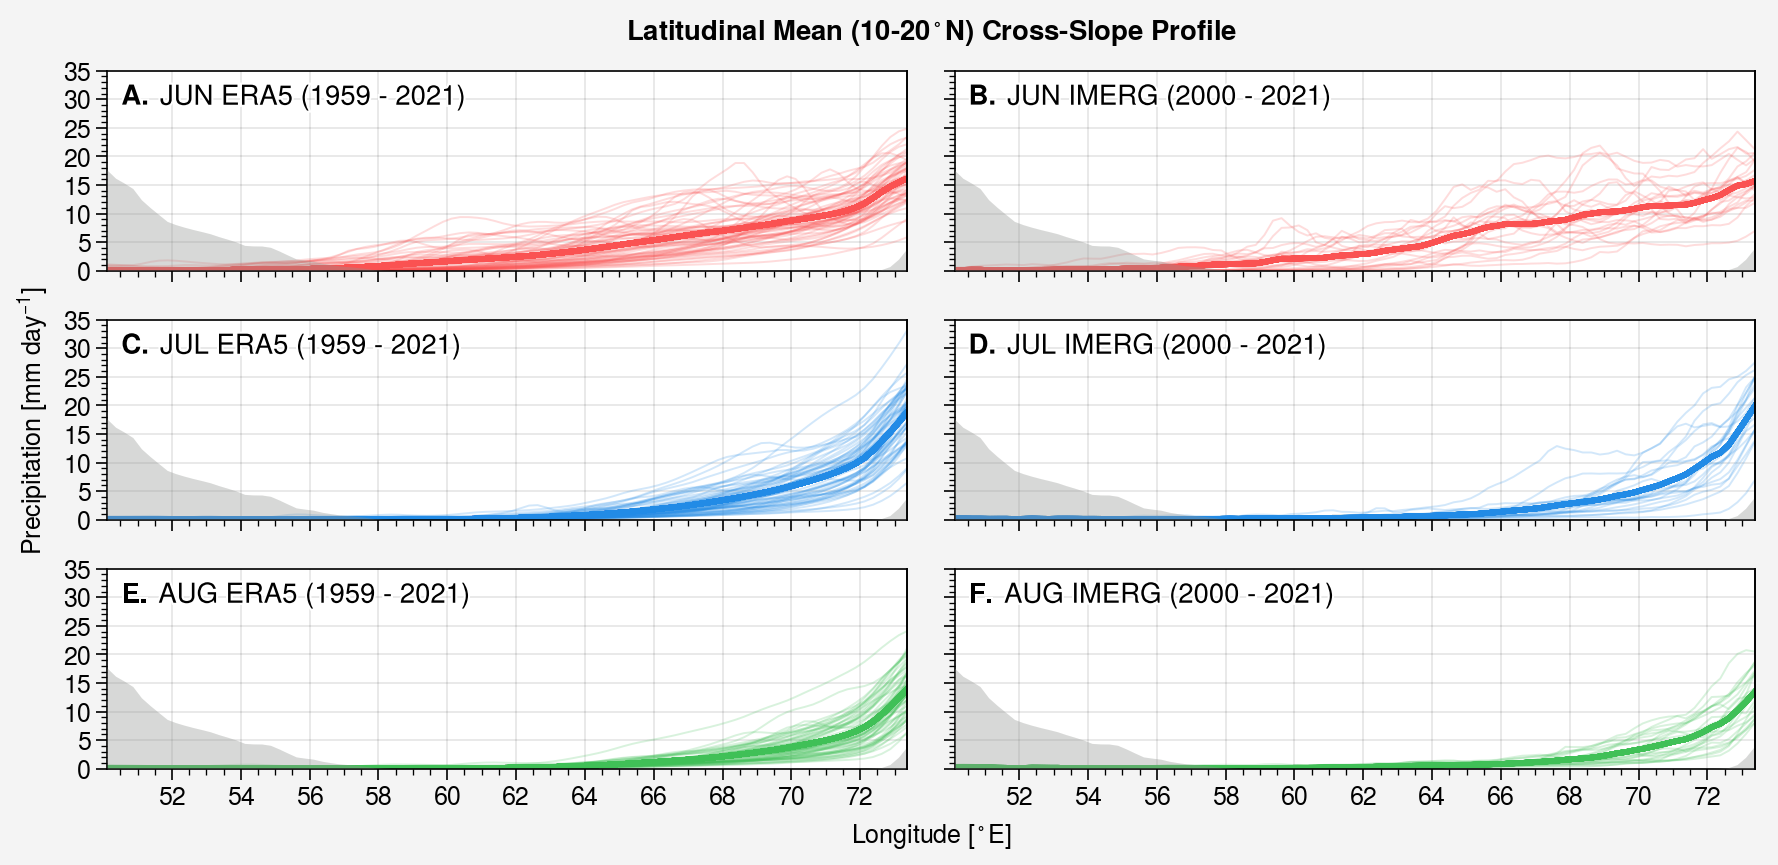

In [4]:
pplt.rc.reso='hi'; colors=np.asarray(['red6','blue6','green6']); alpha=0.2; width=np.asarray([0.7,2])
fig,axs = pplt.subplots(ncols=2,nrows=3,refwidth=4,refheight=1)
axs.format(suptitle='Latitudinal Mean ('+str(lat1)+'-'+str(lat2)+'$^\circ$N) Cross-Slope Profile',abc='A.',abcloc='ul',
           titleloc='ul',xlabel='Longitude [$^\circ$E]',xticks=2,
           ylabel='Precipitation [mm day$^{-1}$]',ylim=(0,35),yticks=5)
oxs = axs.twinx()
oxs.fill_between(lon,z,fc='grey',alpha=alpha,zorder=0)
oxs.format(ylim=(0,0.8),ylabel='',yticks='null')
for i,ax in enumerate(months): 
    for j in range(era5years):
        axs[2*i].plot(lon,era5pr[i,j],colors=colors[i],alpha=alpha,linewidth=width[0])
        axs[2*i].plot(lon,era5pr[i].mean(dim='year'),colors=colors[i],linewidth=width[1])
        axs[2*i].format(titleloc='ul',title=months[i]+' ERA5 (1959 - 2021)')
    for k in range(imergyears):
        axs[2*i+1].plot(lon,imergpr[i,k],colors=colors[i],alpha=alpha,linewidth=width[0])
        axs[2*i+1].plot(lon,imergpr[i].mean(dim='year'),colors=colors[i],linewidth=width[1])
        axs[2*i+1].format(titleloc='ul',title=months[i]+' IMERG (2000 - 2021)')

## Calculate Exponential Fits of Upwind Precipitation

In [5]:
p0=(1,-0.005); maxfev=10000
def exponential(x,a,b):
    return a*np.exp(b*x)
def expfit(years,prdata):
    allparams=[]
    allfittedpr=[]
    for i,month in enumerate(months):    
        params = []
        fittedpr = []
        for j in range(years):
            coeffs,_ = curve_fit(exponential,lon,prdata[i][j],p0=p0,maxfev=maxfev)
            a,b = coeffs[0],coeffs[1]
            params.append(coeffs)
            fittedpr.append(a*np.exp(b*lon))
        allparams.append(params)
        allfittedpr.append(fittedpr)
    paramsbymonth = xr.DataArray(allparams).rename({'dim_0':'month','dim_1':'year','dim_2':'params'})
    fittedprbymonth = xr.DataArray(allfittedpr).rename({'dim_0':'month','dim_1':'year','dim_2':'lon'})
    return paramsbymonth,fittedprbymonth
era5params,era5fittedpr = expfit(era5years,era5pr)
imergparams,imergfittedpr = expfit(imergyears,imergpr)

## Plot Exponential Fits of Upwind Precipitation

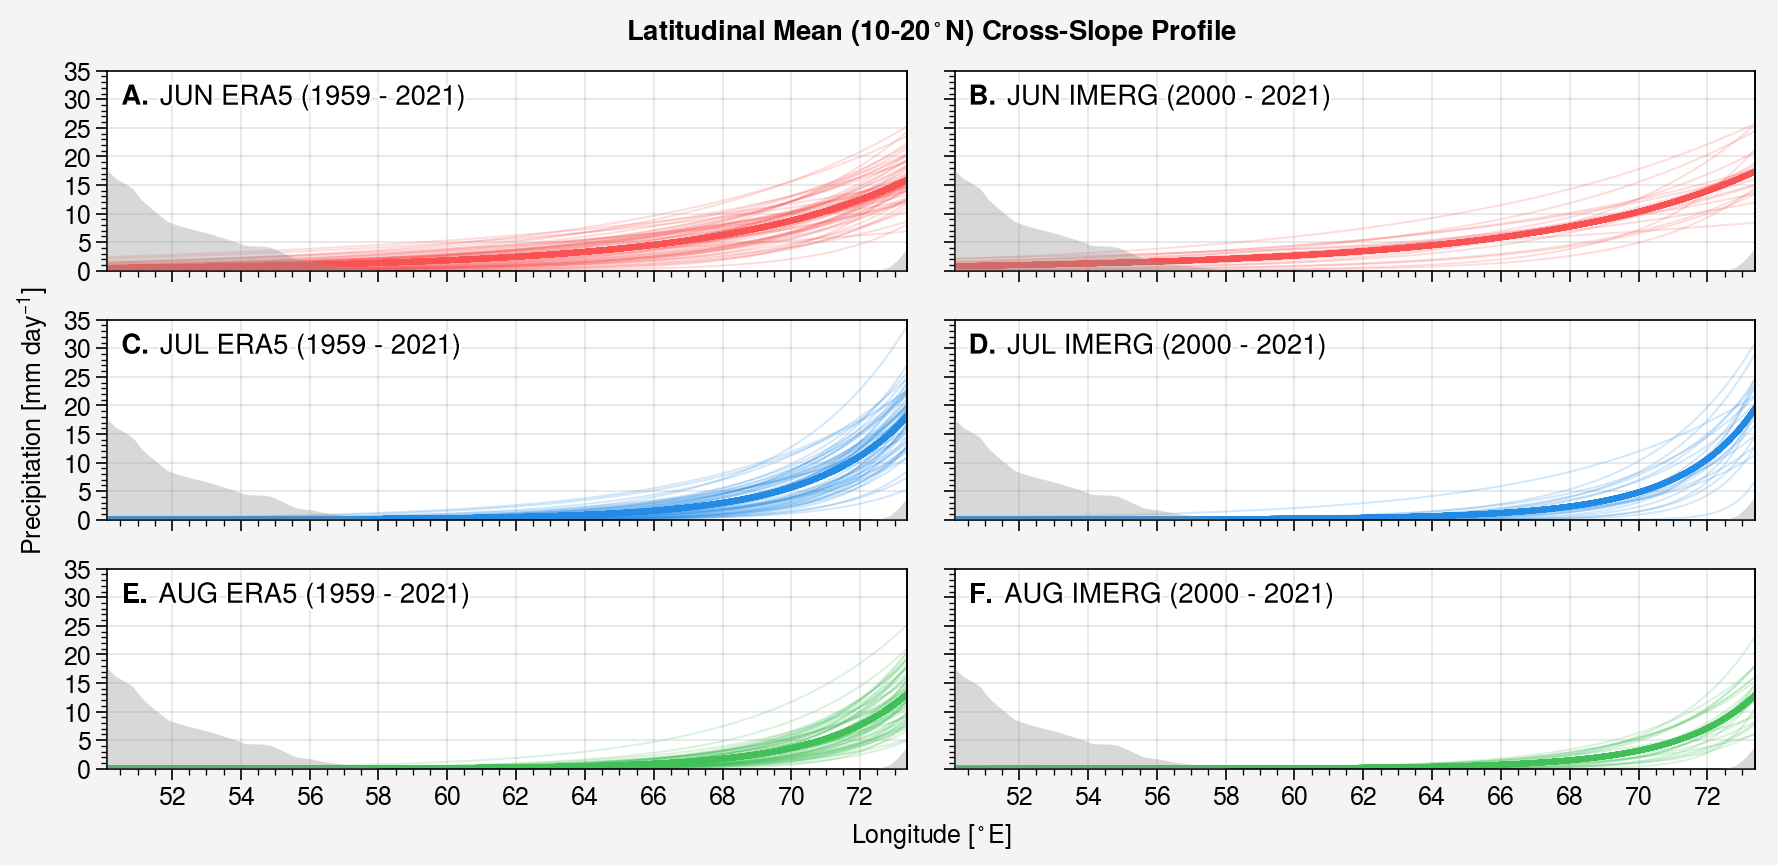

In [6]:
pplt.rc.reso='hi'; colors=np.asarray(['red6','blue6','green6']); alpha=0.2; width=np.asarray([0.7,2])
fig,axs = pplt.subplots(ncols=2,nrows=3,refwidth=4,refheight=1)
axs.format(suptitle='Latitudinal Mean ('+str(lat1)+'-'+str(lat2)+'$^\circ$N) Cross-Slope Profile',
           abc='A.',abcloc='ul',titleloc='ul',xlabel='Longitude [$^\circ$E]',xticks=2,
           ylabel='Precipitation [mm day$^{-1}$]',ylim=(0,35),yticks=5)
oxs = axs.twinx()
oxs.fill_between(lon,z,fc='grey',alpha=alpha,zorder=0)
oxs.format(ylim=(0,0.8),ylabel='',yticks='null')
for i,ax in enumerate(months):    
    for j in range(era5years):    
        axs[2*i].plot(lon,era5fittedpr[i,j],color=colors[i],alpha=alpha,linewidth=width[0])
        axs[2*i].plot(lon,era5fittedpr[i].mean(dim='year'),colors=colors[i],linewidth=width[1])
        axs[2*i].format(title=months[i]+' ERA5 (1959 - 2021)')
    for k in range(imergyears):   
        axs[2*i+1].plot(lon,imergfittedpr[i,k],color=colors[i],alpha=alpha,linewidth=width[0])
        axs[2*i+1].plot(lon,imergfittedpr[i].mean(dim='year'),colors=colors[i],linewidth=width[1])
        axs[2*i+1].format(title=months[i]+' IMERG (2000 - 2021)')

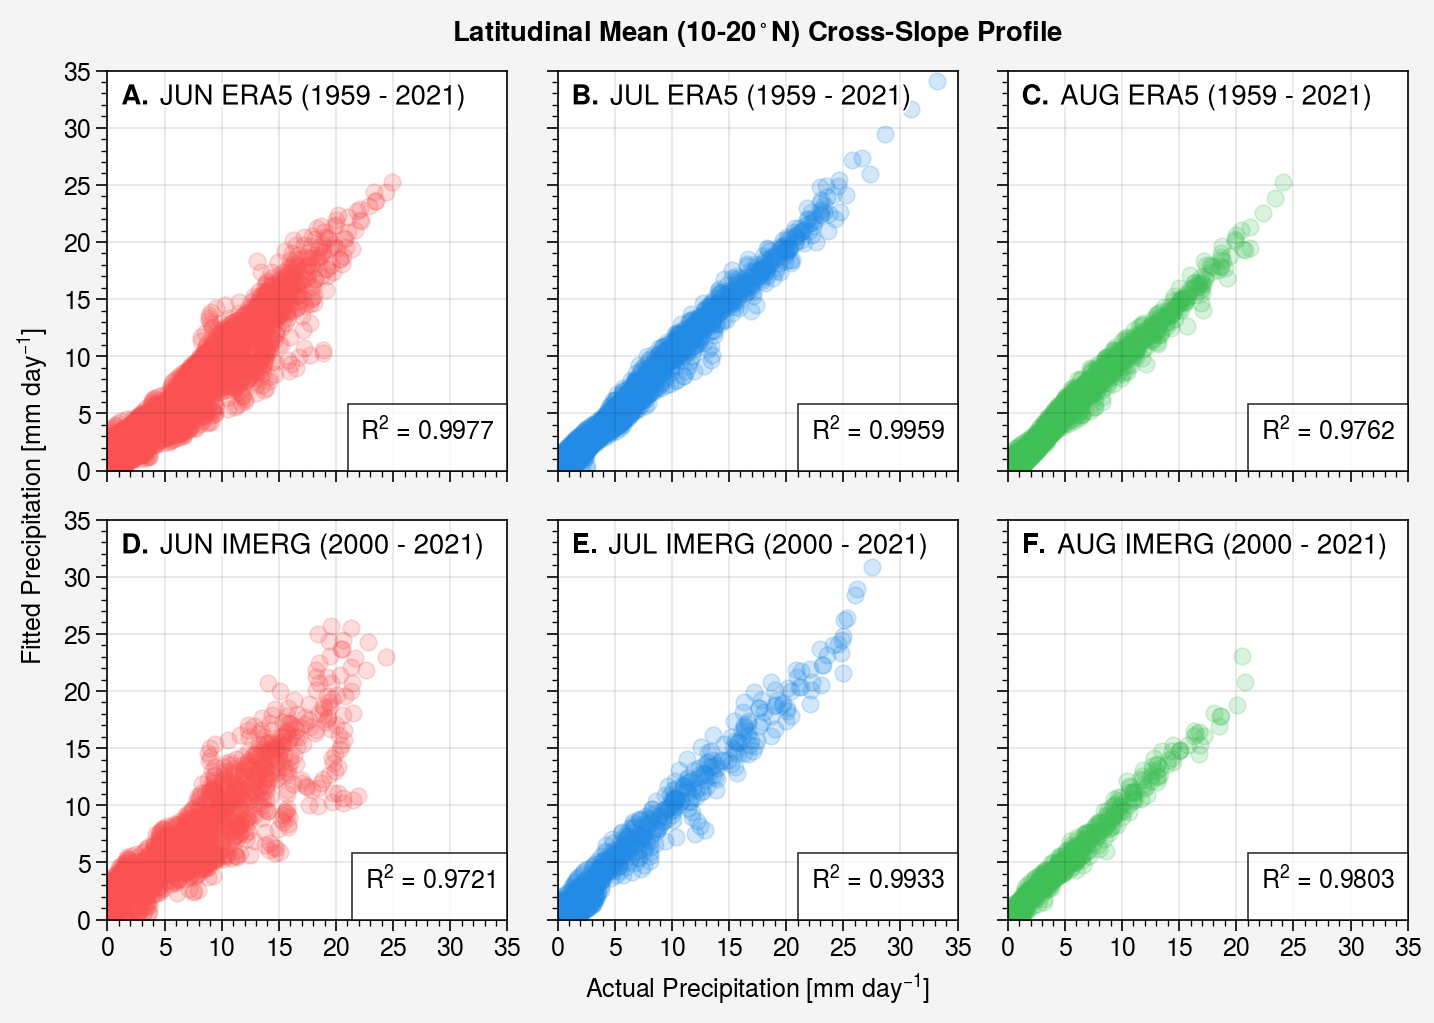

In [7]:
pplt.rc.reso='hi'; colors=np.asarray(['red6','blue6','green6']); alpha=0.2; marker='o'
fig,axs = pplt.subplots(ncols=3,nrows=2,refheight=2,refwidth=2)
axs.format(suptitle='Latitudinal Mean ('+str(lat1)+'-'+str(lat2)+'$^\circ$N) Cross-Slope Profile',
           abc='A.',abcloc='ul',titleloc='ul',xlabel='Actual Precipitation [mm day$^{-1}$]',xlim=(0,35),xticks=5,
           ylabel='Fitted Precipitation [mm day$^{-1}$]',ylim=(0,35), yticks=5) 
for i,ax in enumerate(months):    
    for j in range(era5years):      
        axs[i].scatter(era5pr[i,j],era5fittedpr[i,j],colors=colors[i],alpha=alpha)
        axs[i].format(title=months[i]+' ERA5 (1959 - 2021)') 
    axs[i].legend(loc='lr',label='$R^2$ = '+str('{:.4f}'.format((r2_score(era5pr[i,j],era5fittedpr[i,j])))))
    for k in range(imergyears):      
        axs[i+3].scatter(imergpr[i,k],imergfittedpr[i,k],colors=colors[i],alpha=alpha)
        axs[i+3].format(title=months[i]+' IMERG (2000 - 2021)') 
    axs[i+3].legend(loc='lr',label='$R^2$ = '+str('{:.4f}'.format((r2_score(imergpr[i,k],imergfittedpr[i,k])))))